Date: 2016-09-01
    
The purpose of this notebook is to:
+  Look at examples of sharp wave ripiples
+  Develop code to extract the already computed sharp wave ripples
+  Develop code to compute the sharp wave ripples in the same manner as their code
+  Compare the multitaper sharp wave ripples score to the computed sharp wave ripples

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import os
import sys
import collections
import random
import scipy.io
import scipy.fftpack
import scipy.signal
import scipy.ndimage
import numpy as np
import nitime.algorithms as tsa
import nitime.utils as utils
import nitime.viz
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sns
import pandas as pd
import tqdm
import matplotlib.patches as patches

sys.path.append('../src/')
import data_filter as df
import ripples
import spectral

In [2]:
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

epoch_info = df.make_epochs_dataframe(animals, days)
tetrode_info = df.make_tetrode_dataframe(animals)
epoch_keys = df.get_dataframe_index(epoch_info
    .loc[(['HPa'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'])

cur_tetrode_info = pd.concat([tetrode_info[key] for key in epoch_keys])
cur_tetrode_info

area  depth descrip  numcells
animal day epoch_ind tetrode_number                               
HPa    8   2         1                CA1    113  riptet        12
                     2                CA1    121     NaN         0
                     3                CA1     90  CA1Ref         0
                     4                CA1    116  riptet        15
                     5                CA1    116  riptet         0
                     6                CA1    110  riptet         0
                     7                CA1    114  riptet         0
                     8               iCA1    114  riptet         0
                     9               iCA1    100  riptet         0
                     10              iCA1     96     NaN         0
                     11              iCA1    106  riptet         0
                     12              iCA1    114  riptet         3
                     13              iCA1    120     NaN         0
                     14              iCA1    105  riptet         6
                     15               PFC     93     NaN         0
                     16               PFC     90     NaN         0
                     17               PFC     90     NaN         6
                     18               PFC     90     NaN         0
                     19               PFC    130     NaN         0
                     20               PFC    109     NaN         0

In [3]:
tetrode_index = df.get_dataframe_index(cur_tetrode_info)
lfp_data = df.get_LFP_data(tetrode_index, animals)

## Pre-computed ripples by the Frank Lab

We need some code to access the ripple indicators as computed by the Frank Lab. This is for a baseline comparison to our version of their code and subsequent improvements. First we need to load the data.

In [4]:
day = 8
cur_animal = animals['HPa']
tetrode_number = 1
epoch_ind = 2
ripples_data = df.get_data_structure(cur_animal, day, 'ripples', 'ripples')
ripples_data[epoch_ind - 1][0][tetrode_number - 1].dtype.names

('startind',
 'endind',
 'midind',
 'starttime',
 'endtime',
 'midtime',
 'peak',
 'energy',
 'maxthresh',
 'posind',
 'timerange',
 'samprate',
 'threshold',
 'baseline',
 'std',
 'minimum_duration')

Now that we have the data we want to put it in a more usable format (ripple number, start time of ripple, end time of ripple). We use the ripple number to identify each ripple as its own entity.

In [5]:
times = zip(ripples_data[epoch_ind - 1][0][tetrode_number - 1]['starttime'][0,0].flatten(),
           ripples_data[epoch_ind - 1][0][tetrode_number - 1]['endtime'][0,0].flatten())
r1 = [(ripple_ind + 1, start_time, end_time) for ripple_ind, (start_time, end_time) in enumerate(times)]
print(len(r1))
r1[0]

798


(1, 2717.8274669335847, 2717.8761336029393)

Turn this into a function and compare

In [6]:
def _get_computed_ripple_times(tetrode_tuple, animals):
    ''' Returns a list of tuples for a given tetrode in the format
    (ripple_number, start_index, end_index). The indexes are relative
    to the trial time for that session. Data is extracted from the ripples
    data structure and calculated according to the Frank Lab criterion.
    '''
    animal, day, epoch_ind, tetrode_number = tetrode_tuple
    ripples_data = df.get_data_structure(animals[animal], day, 'ripples', 'ripples')
    start_end = zip(ripples_data[epoch_ind - 1][0][tetrode_number - 1]['starttime'][0, 0].flatten(),
           ripples_data[epoch_ind - 1][0][tetrode_number - 1]['endtime'][0, 0].flatten())
    return [(ripple_ind + 1, start_time, end_time)
            for ripple_ind, (start_time, end_time) in enumerate(start_end)]

r2 = _get_computed_ripple_times(('HPa', 8, 2, 1), animals)
print(len(r2))
r2[0]

798


(1, 2717.8274669335847, 2717.8761336029393)

Use the computed ripple time to plot the ripple to make sure it makes sense

<class 'pandas.core.frame.DataFrame'>
Float64Index: 74 entries, 2717.8275 to 2717.8761
Data columns (total 1 columns):
electric_potential    74 non-null int16
dtypes: int16(1)
memory usage: 740.0 bytes
None


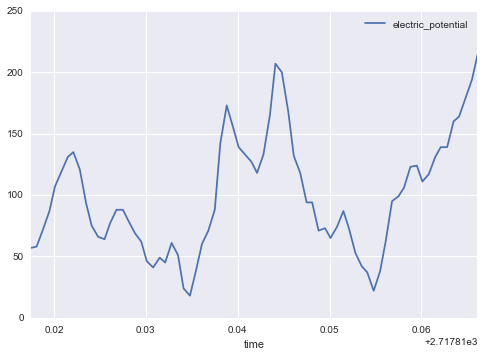

In [7]:
ripple_times = _get_computed_ripple_times(('HPa', 8, 2, 1), animals)
print(lfp_data[0].loc[ripple_times[0][1]:ripple_times[0][2]].info())
lfp_data[0].loc[ripple_times[0][1]:ripple_times[0][2], :].plot()

Now turn this into a pandas dataframe and combine with the LFP dataframe

In [8]:
ripple_df = pd.concat([lfp_data[0].drop(lfp_data[0].columns, axis=1).loc[start_time:end_time].assign(ripple_number=ripple_ind)
                       for ripple_ind, start_time, end_time in ripple_times])
ripple_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 75171 entries, 2717.8275 to 3918.6802
Data columns (total 1 columns):
ripple_number    75171 non-null int64
dtypes: int64(1)
memory usage: 1.1 MB


In [9]:
j = pd.concat([lfp_data[0], ripple_df], axis=1, join_axes=[lfp_data[0].index])
j[j.ripple_number == 1]

,electric_potential,ripple_number
time,,
2717.8275,57,1.0
2717.8281,58,1.0
2717.8288,72,1.0
2717.8295,87,1.0
2717.8301,107,1.0
2717.8308,119,1.0
2717.8315,131,1.0
2717.8321,135,1.0
2717.8328,121,1.0


Make the previous code into a function

In [10]:
def _convert_ripple_times_to_dataframe(ripple_times, dataframe):
    index_dataframe = dataframe.drop(dataframe.columns, axis=1)
    ripple_dataframe = (pd.concat([index_dataframe.loc[start_time:end_time].assign(ripple_number=number)
                                   for number, start_time, end_time in ripple_times]))
    return pd.concat([dataframe, ripple_dataframe], axis=1, join_axes=[dataframe.index])


def get_computed_ripples_dataframe(tetrode_index, animals):
    ripple_times = _get_computed_ripple_times(tetrode_index, animals)
    lfp_dataframe = df._get_LFP_dataframe(tetrode_index, animals)
    return (_convert_ripple_times_to_dataframe(ripple_times, lfp_dataframe)
            .assign(ripple_indicator=lambda x: x.ripple_number.fillna(0) > 0))

get_computed_ripples_dataframe(('HPa', 8, 2, 1), animals).info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1810528 entries, 2712.9948 to 3920.0129
Data columns (total 3 columns):
electric_potential    int16
ripple_number         float64
ripple_indicator      bool
dtypes: bool(1), float64(1), int16(1)
memory usage: 32.8 MB


### Example Sharp Wave Ripples (Frank Lab)
Plot some examples of sharp wave ripples for a single tetrode (Animal HPa, Day 8, Epoch \#2, Tetrode \#1) using the code from the previous section

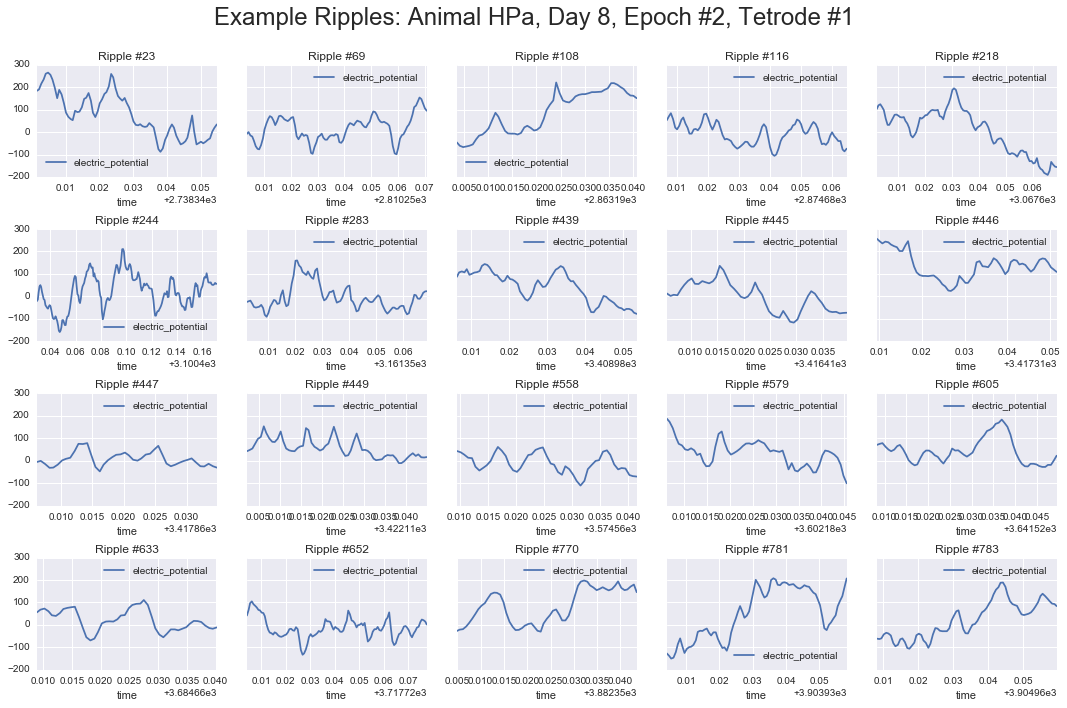

In [11]:
ripple_df = get_computed_ripples_dataframe(('HPa', 8, 2, 1), animals)
ripple_numbers = ripple_df.ripple_number.unique()
num_samples = 20
num_plot_rows = int(np.ceil(num_samples / 5))
ripple_sample_numbers = random.sample(list(ripple_numbers), num_samples)
ripple_sample_index = ripple_df.ripple_number.isin(ripple_sample_numbers)
fig, axis_handles = plt.subplots(num_plot_rows, 5, figsize=(15, 10), sharey=True)
axis_handles = axis_handles.flatten()
for ind, (name, group) in enumerate(ripple_df[ripple_sample_index].groupby('ripple_number')):    
    group.plot(y='electric_potential', ax=axis_handles[ind], title='Ripple #{num}'.format(num=int(name)))

plt.tight_layout()
plt.suptitle('Example Ripples: Animal HPa, Day 8, Epoch #2, Tetrode #1', fontsize=24)
plt.subplots_adjust(top=0.90)

## Our version of the Frank Lab code
The following code is for making sure we understand how the Frank Lab method for extracting the ripples works. From Karlsson, M.P., Frank, L.M., 2009. Awake replay of remote experiences in the hippocampus. Nature Neuroscience 12, 913–918. [doi:10.1038/nn.2344](doi:10.1038/nn.2344):
> SWRs were identified on the basis of peaks in the LFP recorded from one channel from each tetrode in the CA3 and CA1 cell layers. The raw LFP data were bandpass-filtered between 150–250 Hz, and the SWR envelope was determined using a Hilbert transform. The envelope was smoothed with a Gaussian (4-ms s.d.). We initially identified SWR events as sets of times when the smoothed envelope stayed above 3 s.d. of the mean for at least 15 ms on at least one tetrode. We defined the entire SWR as including times immediately before and after that threshold crossing event during which the envelope exceeded the mean. Overlapping SWRs were combined across tetrodes, so many events extended beyond the SWR seen on a single tetrode.

### Ripple Score
The first part of the method is extracting a z-score that indicates an increase in the sharp wave ripple band (150-250 Hz) power. This involves:

+  Bandpass filtering the LFP between 150-250 Hz
+  Extracting the envelope via the Hilbert transform
+  Smoothing the envelope with a Gaussian window with 4 millisecond standard deviation
+  Z-scoring the smoothed envelope and thresholding

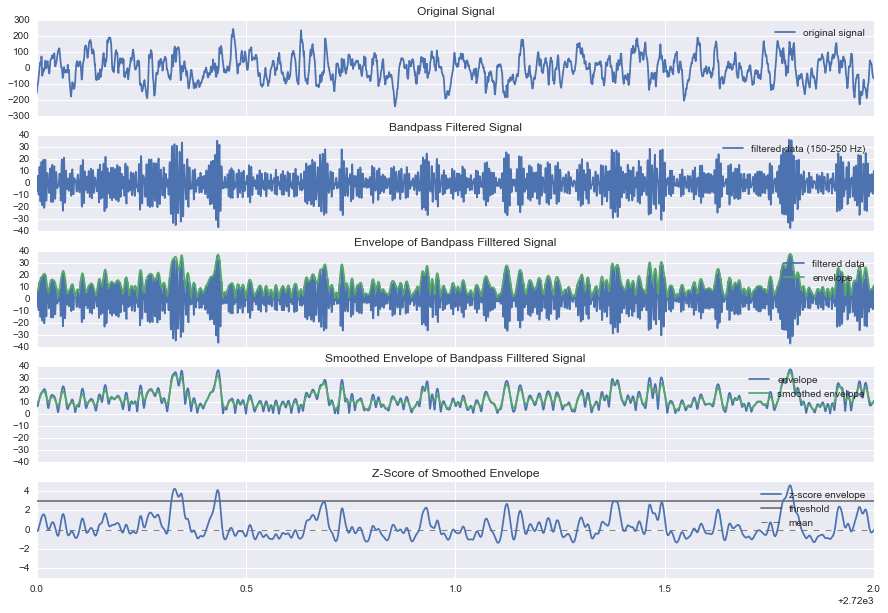

In [12]:
# from: http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
def butter_bandpass(lowcut, highcut, sampling_frequency, order=5):
    nyq = 0.5 * sampling_frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, sampling_frequency, order=5):
    b, a = butter_bandpass(lowcut, highcut, sampling_frequency, order=order)
    return scipy.signal.filtfilt(b, a, data)


def zscore(x):
    return (x - x.mean()) / x.std()

start_time = 2720
end_time = 2722

fig, axis_handles = plt.subplots(5, 1, figsize=(15, 10), sharex=True)

sampling_frequency = 1500
lfp = lfp_data[0]
time = lfp.index.get_values()

# Original Signal
signal = lfp['electric_potential']
axis_handles[0].plot(time, signal, label='original signal')
axis_handles[0].set_xlim((start_time, end_time))
axis_handles[0].set_ylim((-300, 300))
axis_handles[0].legend()
axis_handles[0].set_title('Original Signal')

# Filter between 150-200 Hz
filtered_data = butter_bandpass_filter(signal, 150, 250, sampling_frequency, order=10)
axis_handles[1].plot(time, filtered_data, label='filtered data (150-250 Hz)')
axis_handles[1].set_ylim((-40, 40))
axis_handles[1].legend()
axis_handles[1].set_title('Bandpass Filtered Signal')

# Get the envelope
filtered_data_envelope = abs(scipy.signal.hilbert(filtered_data))
axis_handles[2].plot(time, filtered_data, label='filtered data')
axis_handles[2].plot(time, filtered_data_envelope, label='envelope')
axis_handles[2].set_ylim((-40, 40))
axis_handles[2].legend()
axis_handles[2].set_title('Envelope of Bandpass Filltered Signal')

# Smooth Envelope
sigma = 0.004 * sampling_frequency
smoothed_envelope = scipy.ndimage.filters.gaussian_filter1d(filtered_data_envelope, sigma, truncate=8)
axis_handles[3].plot(time, filtered_data_envelope, label='envelope')
axis_handles[3].plot(time, smoothed_envelope, label='smoothed envelope')
axis_handles[3].set_ylim((-40, 40))
axis_handles[3].legend()
axis_handles[3].set_title('Smoothed Envelope of Bandpass Filltered Signal')

# Z-score
z_smoothed_envelope = zscore(smoothed_envelope)
axis_handles[4].plot(time, z_smoothed_envelope, label='z-score envelope')
axis_handles[4].hlines(3, time.min(), time.max(), label='threshold', alpha=0.5)
axis_handles[4].hlines(0, time.min(), time.max(), label='mean', linestyle='--', linewidth=1, alpha=0.5)
axis_handles[4].set_ylim((-5, 5))
axis_handles[4].legend()
axis_handles[4].set_title('Z-Score of Smoothed Envelope')


Turn into a function and compare to previous plot

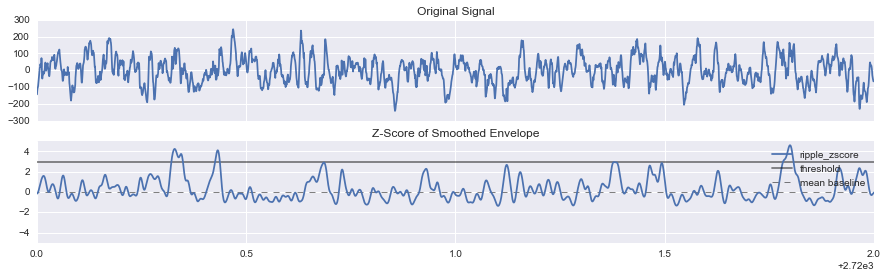

In [13]:
def get_ripple_zscore_frank(lfp, sampling_frequency, sigma=0.004):
    filtered_data = butter_bandpass_filter(lfp['electric_potential'], 150, 250, sampling_frequency, order=10)
    filtered_data_envelope = abs(scipy.signal.hilbert(filtered_data))
    smoothed_envelope = scipy.ndimage.filters.gaussian_filter1d(filtered_data_envelope,
                                                                sigma * sampling_frequency,
                                                                truncate=8)
    
    return (pd.concat([pd.DataFrame({'ripple_zscore': zscore(smoothed_envelope)}), lfp.reset_index()],
                    axis=1).set_index('time'))

fig, axis_handles = plt.subplots(2, 1, figsize=(15, 4), sharex=True)

lfp_data[0].loc[2720:2722, 'electric_potential'].plot(ax=axis_handles[0], title='Original Signal')

ripple = get_ripple_zscore_frank(lfp_data[0], sampling_frequency)
axis_handles[1].plot(ripple['ripple_zscore'])
axis_handles[1].hlines(3, time.min(), time.max(), label='threshold', alpha=0.5)
axis_handles[1].hlines(0, time.min(), time.max(), label='mean baseline', linestyle='--', linewidth=1, alpha=0.5)
axis_handles[1].set_ylim((-5, 5))
axis_handles[0].set_xlim((start_time, end_time))
axis_handles[1].legend()
axis_handles[1].set_title('Z-Score of Smoothed Envelope')

### Segmenting Ripples
The next step after thresholding is to segment the ripples into distinct events and label them. The Frank lab method is to take all segements above the mean baseline (z-score = 0) that contain z-scores above a threshold (typically z-score = 3) for a minimum duration (like 15 milliseconds).

So we have:
+  ripple z-score
+  an indicator function telling us whether the z-score is above the mean baseline
+  an indicator function telling us whether the z-score is above the ripple threshold.

In [14]:
sampling_frequency = 1500
ripple_frank_df = ripples.get_ripple_zscore_frank(lfp_data[0], sampling_frequency)
ripple_frank_df

,ripple_zscore,electric_potential,is_above_ripple_threshold,is_above_ripple_mean
time,,,,
2712.9948,-0.443445,83,False,False
2712.9955,-0.407496,94,False,False
2712.9961,-0.337637,114,False,False
2712.9968,-0.237769,132,False,False
2712.9975,-0.113338,148,False,False
2712.9981,0.029102,152,False,True
2712.9988,0.182378,156,False,True
2712.9995,0.339197,147,False,True
2713.0001,0.492597,145,False,True


Now we need to take the is_above_ripple_mean indicator and label the continuous chunks of time above the threshold as a ripple.

In [15]:
# http://stackoverflow.com/questions/24281936/delimiting-contiguous-regions-with-values-above-a-certain-threshold-in-pandas-da

minimum_duration = 0.015  # in seconds
# False to True
is_start_time = (~ripple_frank_df.is_above_ripple_mean.shift(1).fillna(False)) & ripple_frank_df.is_above_ripple_mean
start_times = ripple_frank_df.index[is_start_time]

# True to False
is_end_time = ripple_frank_df.is_above_ripple_mean & (~ripple_frank_df.is_above_ripple_mean.shift(-1).fillna(False))
end_times = ripple_frank_df.index[is_end_time]

# Handle case of the indicator starting or ending above threshold. Remove these cases from the list
if len(start_times) != len(end_times):
    if end_times[0] > start_times[0]:
        end_times = end_times[1:]
    else:
        start_times = start_times[:-1]
        
ripple_time_list = [(start_time, end_time)
  for start_time, end_time in zip(start_times, end_times)
  if end_time >= (start_time + minimum_duration)]

# Check format
print(ripple_time_list[0:2])

# Make sure everything has the right duration
print(all([(end - start) > minimum_duration for start, end in ripple_time_list]))

[(2712.9980999999998, 2713.0140999999999), (2713.1581000000001, 2713.1741000000002)]
True


Turn into a function

In [16]:
def _get_series_start_end_times(series):
    ''' Returns a two element tuple of the start of the segment
    and the end of the segment. The input series must be a boolean
    pandas series where the index is time.
    '''
    is_start_time = (~series.shift(1).fillna(False)) & series
    start_times = series.index[is_start_time]

    is_end_time = series & (~series.shift(-1).fillna(False))
    end_times = series.index[is_end_time]

    # Handle case of the indicator starting or ending above threshold.
    # Remove these cases from the list
    if len(start_times) != len(end_times):
        if end_times[0] > start_times[0]:
            end_times = end_times[1:]
        else:
            start_times = start_times[:-1]
    
    return start_times, end_times

def segment_boolean_series(series, minimum_duration=0.015):
    ''' Returns a list of tuples where each tuple contains the
    start time of segement and end time of segment. It takes 
    a boolean pandas series as input where the index is time.
    
    '''
    start_times, end_times = _get_series_start_end_times(series)

    return [(start_time, end_time)
                     for start_time, end_time in zip(start_times, end_times)
                     if end_time >= (start_time + minimum_duration)]


ripple_time_list2 = segment_boolean_series(ripple_frank_df.is_above_ripple_mean)

# Check format
print(ripple_time_list2[0:2])

# Make sure everything has the right duration
print(all([(end - start) > minimum_duration for start, end in ripple_time_list2]))

[(2712.9980999999998, 2713.0140999999999), (2713.1581000000001, 2713.1741000000002)]
True


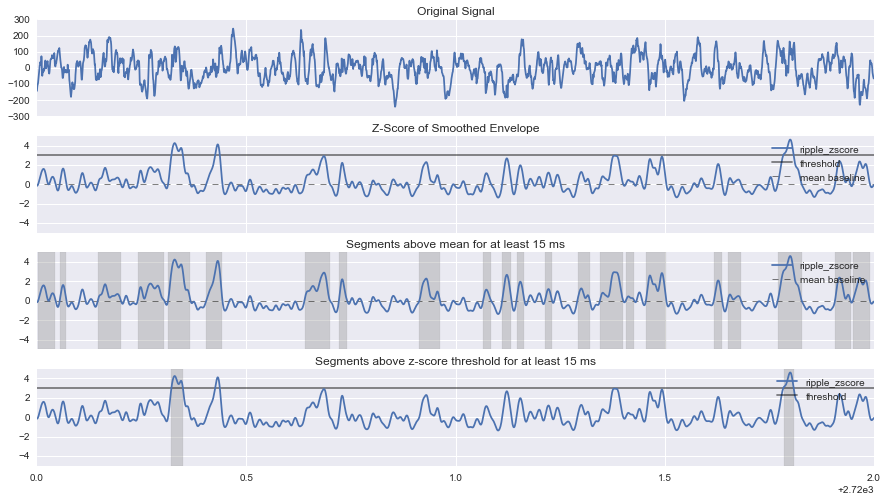

In [17]:
def create_box(segment, y_low=-5, height=10, alpha=0.3, color='grey'):
    return patches.Rectangle((segment[0], y_low),
                             segment[1] - segment[0],
                             height,
                             alpha=alpha, color=color)

fig, axis_handles = plt.subplots(4, 1, figsize=(15, 8), sharex=True)

start_time = 2720
end_time = 2722

lfp_data[0].loc[start_time:end_time, 'electric_potential'].plot(ax=axis_handles[0], title='Original Signal')

ripple_frank_df = ripples.get_ripple_zscore_frank(lfp_data[0], sampling_frequency)

axis_handles[1].plot(ripple_frank_df.loc[start_time:end_time, 'ripple_zscore'])
axis_handles[1].hlines(3, time.min(), time.max(), label='threshold', alpha=0.5)
axis_handles[1].hlines(0, time.min(), time.max(), label='mean baseline', linestyle='--', linewidth=1, alpha=0.5)
axis_handles[1].set_ylim((-5, 5))
axis_handles[1].legend()
axis_handles[1].set_title('Z-Score of Smoothed Envelope')

ripple_above_mean_segments = segment_boolean_series(ripple_frank_df.loc[start_time:end_time, 'is_above_ripple_mean'])
axis_handles[2].plot(ripple_frank_df.loc[start_time:end_time, 'ripple_zscore'])
axis_handles[2].hlines(0, time.min(), time.max(), label='mean baseline', linestyle='--', linewidth=1, alpha=0.5)
for segment in ripple_above_mean_segments:
        axis_handles[2].add_patch(create_box(segment))

axis_handles[2].set_ylim((-5, 5))
axis_handles[2].legend()
axis_handles[2].set_title('Segments above mean for at least 15 ms')

ripple_above_threshold_segments = segment_boolean_series(ripple_frank_df.loc[start_time:end_time, 'is_above_ripple_threshold'])

axis_handles[3].plot(ripple_frank_df.loc[start_time:end_time, 'ripple_zscore'])
axis_handles[3].hlines(3, time.min(), time.max(), label='threshold', alpha=0.5)
for segment in ripple_above_threshold_segments:
        axis_handles[3].add_patch(create_box(segment))
        
axis_handles[3].set_ylim((-5, 5))
axis_handles[3].legend()
axis_handles[3].set_title('Segments above z-score threshold for at least 15 ms')

### Extending the ripple segments
Now we want to take these ripple segments and extend them so that the start and end times are when the z-score crosses the mean baseline (on its way up or way down respectively)

In [18]:
# First segment
start1, end1 = ripple_time_list[0]
print(start1, end1)
segment_df = ripple_frank_df.loc[start1:end1]
segment_df

2712.9981 2713.0141


,ripple_zscore,electric_potential,is_above_ripple_threshold,is_above_ripple_mean
time,,,,
2712.9981,0.029102,152,False,True
2712.9988,0.182378,156,False,True
2712.9995,0.339197,147,False,True
2713.0001,0.492597,145,False,True
2713.0008,0.636322,135,False,True
2713.0015,0.765094,119,False,True
2713.0021,0.874779,107,False,True
2713.0028,0.962453,91,False,True
2713.0035,1.026379,47,False,True


In [19]:
ripple_threshold_list = segment_boolean_series(ripple_frank_df.is_above_ripple_threshold)
ripple_baseline_list = segment_boolean_series(ripple_frank_df.is_above_ripple_mean)

baseline_start = np.asarray(ripple_baseline_list)[:,0]
threshold_start = ripple_threshold_list[0][0]
print(ripple_threshold_list[0])
print(ripple_baseline_list[np.max((baseline_start - threshold_start < 0).nonzero())])

(2720.3215, 2720.3481000000002)
(2720.3135000000002, 2720.3667999999998)


Make into a function

In [20]:
def _find_containing_interval(interval_candidates, target_interval):
    '''Returns the interval that contains the target interval out of a list of 
    interval candidates. This is accomplished by finding the closest start time
    out of the candidate intervals, since we already know that one interval candidate
    contains the target interval (the segements above 0 contain the segments above
    the threshold)'''
    candidate_start_times = np.asarray(interval_candidates)[:,0]
    closest_start_ind = np.max((candidate_start_times - target_interval[0] < 0).nonzero())
    return interval_candidates[closest_start_ind]


def extend_segment_intervals(ripple_above_threshold_segments, ripple_above_mean_segments):
    ''' Returns a list of tuples that extend the
    boundaries of the segments by the ripple threshold (i.e ripple z-score > 3)
    to the boundaries of a containing interval defined by when the z-score
    crosses the mean.
    '''
    return [_find_containing_interval(ripple_above_mean_segments, segment)
            for segment in ripple_above_threshold_segments]

ripple_above_threshold_segments = segment_boolean_series(ripple_frank_df.is_above_ripple_threshold)
ripple_above_mean_segments = segment_boolean_series(ripple_frank_df.is_above_ripple_mean)
extended_segments = extend_segment_intervals(ripple_above_threshold_segments, ripple_above_mean_segments)

print(ripple_above_threshold_segments[0:2])
print(extended_segments[0:2])

[(2720.3215, 2720.3481000000002), (2721.7835, 2721.8074999999999)]
[(2720.3135000000002, 2720.3667999999998), (2721.7701000000002, 2721.8267999999998)]


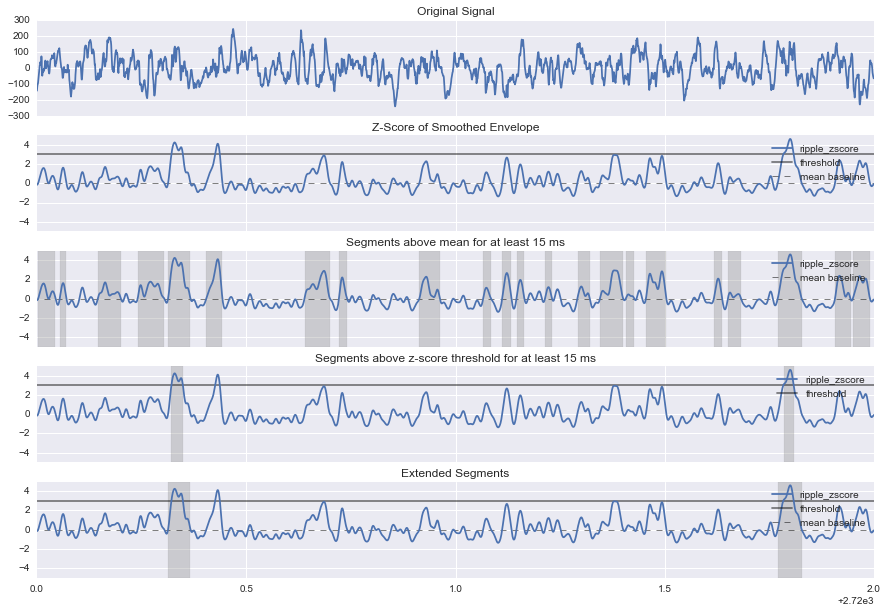

In [21]:
fig, axis_handles = plt.subplots(5, 1, figsize=(15, 10), sharex=True)

start_time = 2720
end_time = 2722

lfp_data[0].loc[start_time:end_time, 'electric_potential'].plot(ax=axis_handles[0], title='Original Signal')

ripple_frank_df = ripples.get_ripple_zscore_frank(lfp_data[0], sampling_frequency)

axis_handles[1].plot(ripple_frank_df.loc[start_time:end_time, 'ripple_zscore'])
axis_handles[1].hlines(3, time.min(), time.max(), label='threshold', alpha=0.5)
axis_handles[1].hlines(0, time.min(), time.max(), label='mean baseline', linestyle='--', linewidth=1, alpha=0.5)
axis_handles[1].set_ylim((-5, 5))
axis_handles[1].legend()
axis_handles[1].set_title('Z-Score of Smoothed Envelope')

ripple_above_mean_segments = segment_boolean_series(ripple_frank_df.loc[start_time:end_time, 'is_above_ripple_mean'])
axis_handles[2].plot(ripple_frank_df.loc[start_time:end_time, 'ripple_zscore'])
axis_handles[2].hlines(0, time.min(), time.max(), label='mean baseline', linestyle='--', linewidth=1, alpha=0.5)
for segment in ripple_above_mean_segments:
        axis_handles[2].add_patch(create_box(segment))

axis_handles[2].set_ylim((-5, 5))
axis_handles[2].legend()
axis_handles[2].set_title('Segments above mean for at least 15 ms')

ripple_above_threshold_segments = segment_boolean_series(ripple_frank_df.loc[start_time:end_time, 'is_above_ripple_threshold'])

axis_handles[3].plot(ripple_frank_df.loc[start_time:end_time, 'ripple_zscore'])
axis_handles[3].hlines(3, time.min(), time.max(), label='threshold', alpha=0.5)
for segment in ripple_above_threshold_segments:
        axis_handles[3].add_patch(create_box(segment))
        
axis_handles[3].set_ylim((-5, 5))
axis_handles[3].legend()
axis_handles[3].set_title('Segments above z-score threshold for at least 15 ms')

extended_segments = extend_segment_intervals(ripple_above_threshold_segments, ripple_above_mean_segments)

axis_handles[4].plot(ripple_frank_df.loc[start_time:end_time, 'ripple_zscore'])
axis_handles[4].hlines(3, time.min(), time.max(), label='threshold', alpha=0.5)
for segment in extended_segments:
        axis_handles[4].add_patch(create_box(segment))
axis_handles[4].hlines(0, time.min(), time.max(), label='mean baseline', linestyle='--', linewidth=1, alpha=0.5)
axis_handles[4].set_ylim((-5, 5))
axis_handles[4].legend()
axis_handles[4].set_title('Extended Segments')

### Combine overlapping segment intervals on all hippocampal tetrodes
Since the sharp-wave ripple is a population event, the Frank Lab combines all overlapping segements to make one big ripple. I think this means that if two tetrodes have overlapping segments, they will both have the same segment marked as a ripple.

Alternatively, segment could be marked as a ripple on all tetrodes. This doesn't seem to be the case though, the number of ripples on each tetrode are different.

First we need some code to access just the hippocampal tetrodes

In [22]:
def filter_list_by_pandas_series(list_to_filter, pandas_boolean_series):
    ''' Convenience function for filtering a list by the criterion of a pandas series
    Returns a list.
    '''
    is_in_list = list(pandas_boolean_series)
    if len(list_to_filter) != len(is_in_list):
        raise ValueError('list to filter must be the same length as the pandas series')
    return [list_element for list_element, is_in_list in zip(list_to_filter, is_in_list) if is_in_list]

CA1_lfp = filter_list_by_pandas_series(lfp_data, cur_tetrode_info.area == 'CA1')
print(len(CA1_lfp))
print(len(filter_list_by_pandas_series(lfp_data, cur_tetrode_info.area.isin(['iCA1', 'PFC']))))

has_cells = cur_tetrode_info.area.isin(['iCA1', 'PFC']) & (cur_tetrode_info.numcells > 0)
print(len(filter_list_by_pandas_series(lfp_data, has_cells)))

# print(len(filter_list_by_pandas_series(lfp_data[0], has_cells)))

7
13
3


Then we need a function to combine the getting the zscore, segmenting, and extending segments step for each tetrode

In [23]:
def get_segments_frank(lfp_dataframe, sampling_frequency, zscore_threshold=3, sigma=0.004, filter_order=10):
    ripple_frank_df = ripples.get_ripple_zscore_frank(lfp_dataframe,
                                                      sampling_frequency,
                                                      zscore_threshold=zscore_threshold,
                                                      sigma=sigma,
                                                      filter_order=filter_order)
    ripple_above_mean_segments = segment_boolean_series(ripple_frank_df.is_above_ripple_mean)
    ripple_above_threshold_segments = segment_boolean_series(ripple_frank_df.is_above_ripple_threshold)
    return extend_segment_intervals(ripple_above_threshold_segments, ripple_above_mean_segments)

segments = get_segments_frank(lfp_data[0], 1500)
segments[0:2]

[(2720.3135000000002, 2720.3667999999998),
 (2721.7701000000002, 2721.8267999999998)]

Now compute this on all CA1 tetrodes (should we include iCA1 tetrodes?)

In [24]:
CA1_lfp = filter_list_by_pandas_series(lfp_data, cur_tetrode_info.area == 'CA1')
segments = [get_segments_frank(lfp, 1500) for lfp in tqdm.tqdm_notebook(CA1_lfp, desc='segments')]
zscores = [ripples.get_ripple_zscore_frank(lfp, 1500) for lfp in tqdm.tqdm_notebook(CA1_lfp, desc='zscores')]

Plot all the tetrodes over the (2991 sec, 3002 sec) range

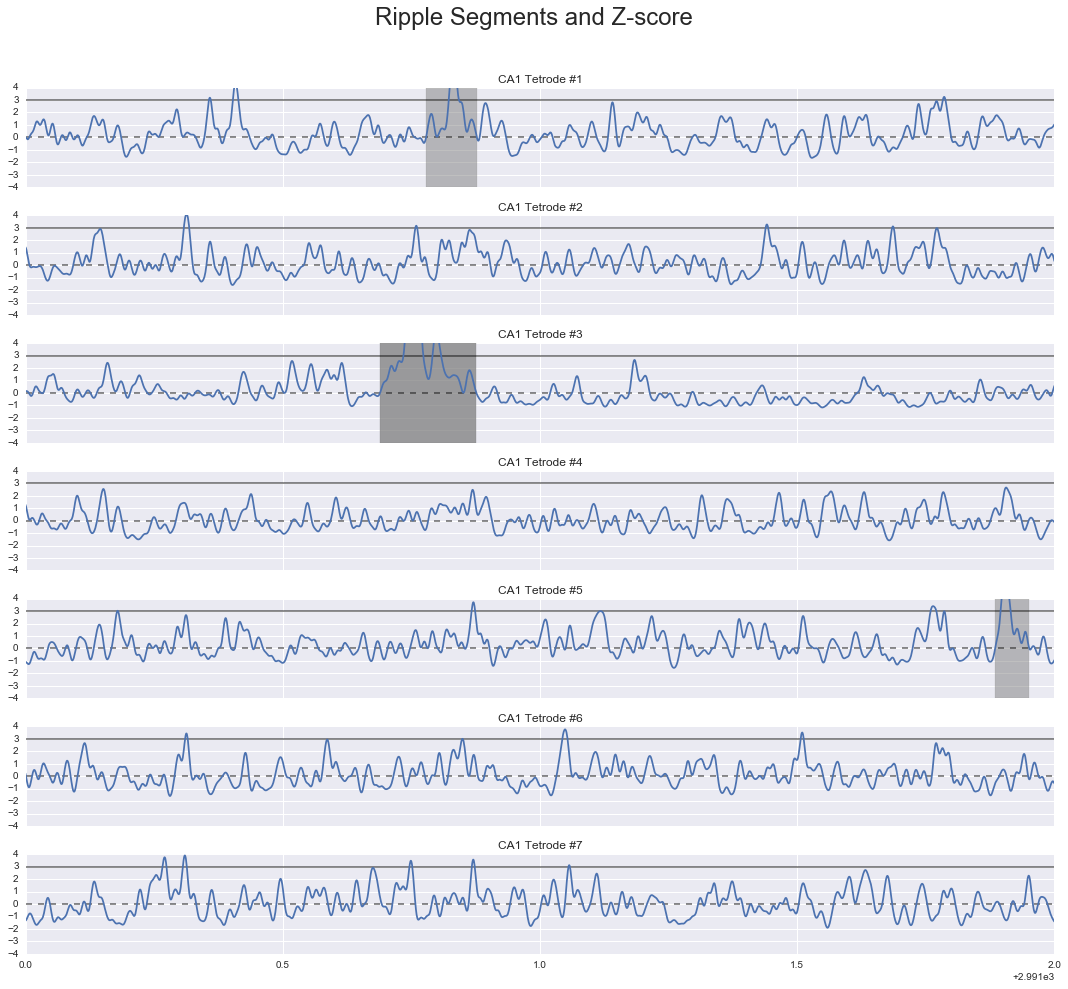

In [25]:
num_tetrodes = len(segments)
time_extent = (2991, 2993)
CA1_tetrode_info = cur_tetrode_info[cur_tetrode_info.area == 'CA1']
CA1_index = list(CA1_tetrode_info.index)

# Z-score
# min_zscore = np.min([z.ripple_zscore.min() for z in zscores])
# max_zscore = np.max([z.ripple_zscore.max() for z in zscores])
min_zscore = -4
max_zscore = 4
z_score_height = max_zscore - min_zscore

fig, axis_handles = plt.subplots(num_tetrodes, 1, figsize=(15, num_tetrodes * 2), sharex=True, sharey=True)
for tetrode_ind, axis_handle in enumerate(axis_handles.flatten()):
    axis_handle.plot(zscores[tetrode_ind].ripple_zscore)
    axis_handle.set_xlim(time_extent)
    axis_handle.set_ylim((min_zscore, max_zscore))
    axis_handle.set_title(spectral.tetrode_title(CA1_index[tetrode_ind], CA1_tetrode_info))
    axis_handle.hlines(3, time_extent[0], time_extent[1], label='threshold', alpha=0.5)
    axis_handle.hlines(0, time_extent[0], time_extent[1], label='mean baseline', linestyle='--', alpha=0.5)
    for segment in segments[tetrode_ind]:
        axis_handle.add_patch(create_box(segment, y_low=min_zscore, height=z_score_height, alpha=0.5))
        
plt.tight_layout()
plt.suptitle('Ripple Segments and Z-score', fontsize=24)
plt.subplots_adjust(top=0.90)

In [26]:
# LFP
# min_lfp = -600
# max_lfp = 600
# lfp_height = max_lfp - min_lfp
        
# fig, axis_handles = plt.subplots(num_tetrodes, 1, figsize=(15, num_tetrodes * 2), sharex=True, sharey=True)
# for tetrode_ind, axis_handle in enumerate(axis_handles.flatten()):
#     axis_handle.plot(lfp_data[tetrode_ind].electric_potential)
#     axis_handle.set_xlim(time_extent)
#     axis_handle.set_ylim((min_lfp, max_lfp))
#     axis_handle.set_title(spectral.tetrode_title(CA1_index[tetrode_ind], CA1_tetrode_info))
#     for segment in segments[tetrode_ind]:
#         axis_handle.add_patch(create_box(segment, y_low=min_lfp, height=lfp_height, alpha=0.5))

# plt.tight_layout()
# plt.suptitle('Ripple Segments and LFP', fontsize=24)
# plt.subplots_adjust(top=0.90)

Compare to the extracted ripples

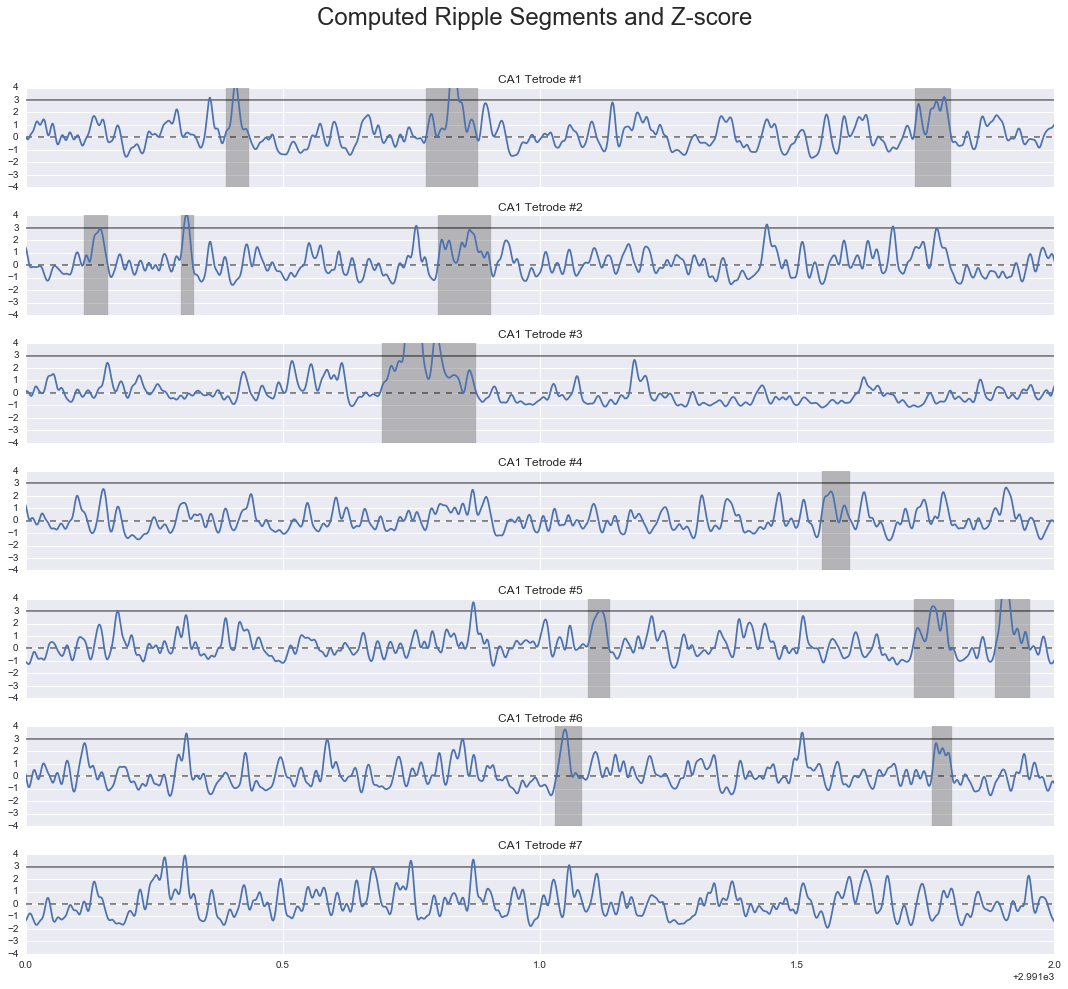

In [27]:
computed_ripple_times = [_get_computed_ripple_times(index, animals) for index in CA1_index]

# Z-score
# min_zscore = np.min([z.ripple_zscore.min() for z in zscores])
# max_zscore = np.max([z.ripple_zscore.max() for z in zscores])
min_zscore = -4
max_zscore = 4
z_score_height = max_zscore - min_zscore

fig, axis_handles = plt.subplots(num_tetrodes, 1, figsize=(15, num_tetrodes * 2), sharex=True, sharey=True)
for tetrode_ind, axis_handle in enumerate(axis_handles.flatten()):
    axis_handle.plot(zscores[tetrode_ind].ripple_zscore)
    axis_handle.set_xlim(time_extent)
    axis_handle.set_ylim((min_zscore, max_zscore))
    axis_handle.hlines(3, time_extent[0], time_extent[1], label='threshold', alpha=0.5)
    axis_handle.hlines(0, time_extent[0], time_extent[1], label='mean baseline', linestyle='--', alpha=0.5)
    axis_handle.set_title(spectral.tetrode_title(CA1_index[tetrode_ind], CA1_tetrode_info))
        
    for segment in computed_ripple_times[tetrode_ind]:
        axis_handle.add_patch(create_box(segment[1:3], y_low=min_zscore, height=z_score_height, alpha=0.5))
    
#     for segment in segments[tetrode_ind]:
#         axis_handle.add_patch(create_box(segment, y_low=min_zscore, height=z_score_height, alpha=0.1, color='red'))
        
plt.tight_layout()
plt.suptitle('Computed Ripple Segments and Z-score', fontsize=24)
plt.subplots_adjust(top=0.90)

The computed z-score and my code don't seem to match. One reason is the threshold reported in the paper is 3 standard deviations but the ripple structure in matlab is thresholded at 2 standard deviations.

In [28]:
day = 8
cur_animal = animals['HPa']
tetrode_number = 1
epoch_ind = 2
ripples_data = df.get_data_structure(cur_animal, day, 'ripples', 'ripples')
computed_std = ripples_data[epoch_ind - 1][0][tetrode_number - 1]['std'][0,0][0][0]
computed_threshold = ripples_data[epoch_ind - 1][0][tetrode_number - 1]['threshold'][0,0][0][0]
computed_baseline = ripples_data[epoch_ind - 1][0][tetrode_number - 1]['baseline'][0,0][0][0]
print('The computed mean of the smoothed envelope for tetrode #{tetrode} is: {baseline:.4f}'.format(
        baseline=computed_baseline, tetrode=tetrode_number))
print('The computed standard deviation of the smoothed envelope for tetrode #{tetrode} is: {std:.4f}'.format(
        std=computed_std, tetrode=tetrode_number))
print('The computed threshold of the smoothed envelope for tetrode #{tetrode} is: {threshold:.4f}'.format(
        threshold=computed_threshold, tetrode=tetrode_number))
print('The threshold = mean + standard deviations * x where x is some number of standard deviations')
print('x should equal 3 standard deviations according to Jadhav et al. 2016')
x = (computed_threshold - computed_baseline) / computed_std
print('but x = {x:.1f}'.format(x=x))

The computed mean of the smoothed envelope for tetrode #1 is: 11.2291
The computed standard deviation of the smoothed envelope for tetrode #1 is: 5.4573
The computed threshold of the smoothed envelope for tetrode #1 is: 22.1437
The threshold = mean + standard deviations * x where x is some number of standard deviations
x should equal 3 standard deviations according to Jadhav et al. 2016
but x = 2.0


So if we change the z-score threshold to 2, we get more similarities between the ripple segments, but it's still not the same.

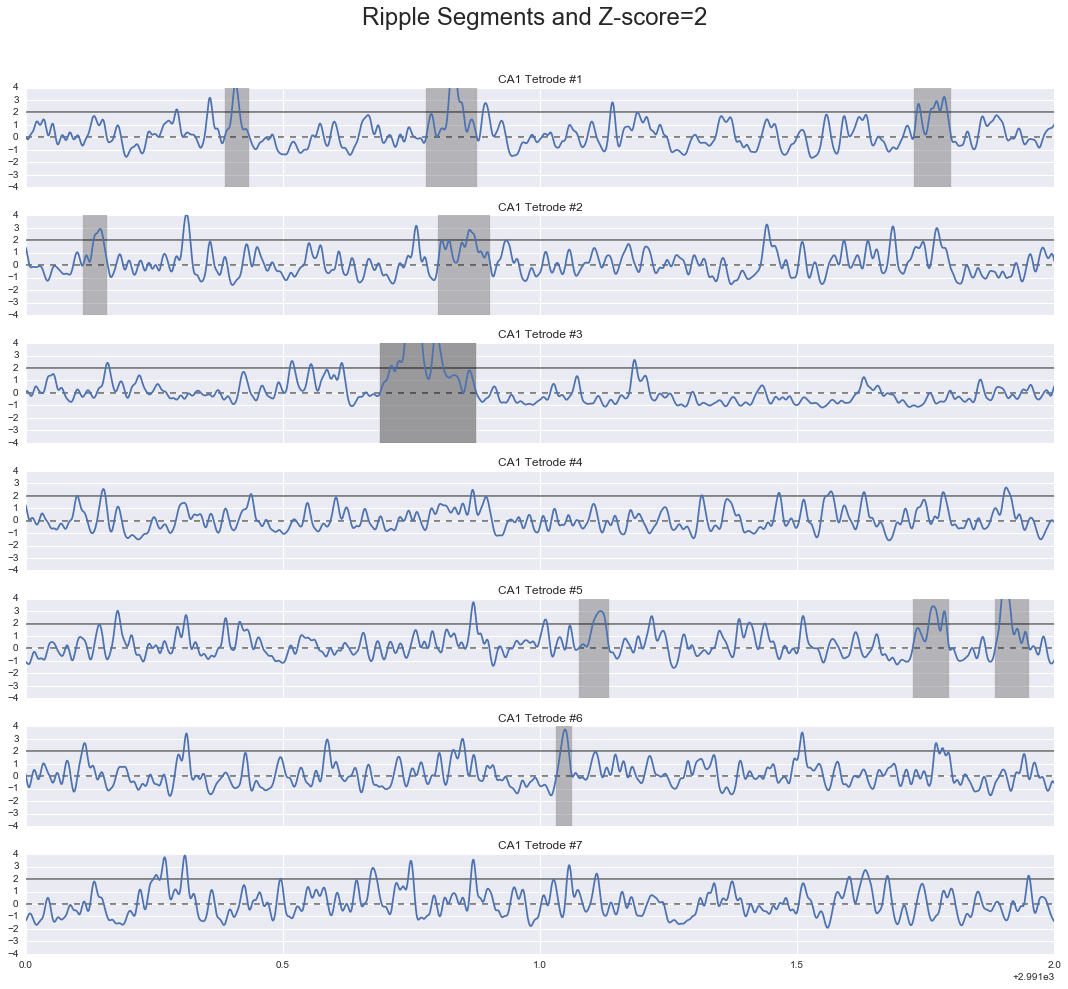

In [29]:
segments2 = [get_segments_frank(lfp, 1500, zscore_threshold=2) for lfp in tqdm.tqdm_notebook(CA1_lfp, desc='segments')]
zscores2 = [ripples.get_ripple_zscore_frank(lfp, 1500, zscore_threshold=2)
            for lfp in tqdm.tqdm_notebook(CA1_lfp, desc='zscores')]

num_tetrodes = len(segments2)
time_extent = (2991, 2993)
CA1_tetrode_info = cur_tetrode_info[cur_tetrode_info.area == 'CA1']
CA1_index = list(CA1_tetrode_info.index)

# Z-score
# min_zscore = np.min([z.ripple_zscore.min() for z in zscores])
# max_zscore = np.max([z.ripple_zscore.max() for z in zscores])
min_zscore = -4
max_zscore = 4
z_score_height = max_zscore - min_zscore

fig, axis_handles = plt.subplots(num_tetrodes, 1, figsize=(15, num_tetrodes * 2), sharex=True, sharey=True)
for tetrode_ind, axis_handle in enumerate(axis_handles.flatten()):
    axis_handle.plot(zscores2[tetrode_ind].ripple_zscore)
    axis_handle.set_xlim(time_extent)
    axis_handle.set_ylim((min_zscore, max_zscore))
    axis_handle.set_title(spectral.tetrode_title(CA1_index[tetrode_ind], CA1_tetrode_info))
    axis_handle.hlines(2, time_extent[0], time_extent[1], label='threshold', alpha=0.5)
    axis_handle.hlines(0, time_extent[0], time_extent[1], label='mean baseline', linestyle='--', alpha=0.5)
    for segment in segments2[tetrode_ind]:
        axis_handle.add_patch(create_box(segment, y_low=min_zscore, height=z_score_height, alpha=0.5))
        
plt.tight_layout()
plt.suptitle('Ripple Segments and Z-score=2', fontsize=24)
plt.subplots_adjust(top=0.90)

Another problem is that the means for the smoothed envelope are different.

In [30]:
cur_animal = animals['HPa']
day = 8
epoch_ind = 2
tetrode_number = 1

sampling_frequency = 1500
sigma = 0.004
ripples_data = df.get_data_structure(cur_animal, day, 'ripples', 'ripples')

computed_baseline = ripples_data[epoch_ind - 1][0][tetrode_number - 1]['baseline'][0,0][0][0]
computed_std = ripples_data[epoch_ind - 1][0][tetrode_number - 1]['std'][0,0][0][0]

print('The computed mean of the smoothed envelope for tetrode #{tetrode} is: {baseline:.4f}'.format(
        baseline=computed_baseline, tetrode=tetrode_number))
print('The computed standard deviation of the smoothed envelope for tetrode #{tetrode} is: {std:.4f}\n'.format(
        std=computed_std, tetrode=tetrode_number))

signal = lfp_data[tetrode_number - 1]['electric_potential']
filtered_data = butter_bandpass_filter(signal, 150, 250, sampling_frequency, order=10)
filtered_data_envelope = abs(scipy.signal.hilbert(filtered_data))
smoothed_envelope = scipy.ndimage.filters.gaussian_filter1d(filtered_data_envelope,
                                                            sigma * sampling_frequency,
                                                            truncate=8)

print('My mean of the smoothed envelope for tetrode #{tetrode} is: {baseline:.4f}'.format(
        baseline=smoothed_envelope.mean(), tetrode=tetrode_number))
print('My standard deviation of the smoothed envelope for tetrode #{tetrode} is: {std:.4f}\n'.format(
        std=smoothed_envelope.std(), tetrode=tetrode_number))

print('Error of mean of the smoothed envelope for tetrode #{tetrode} is: {baseline:.4f}'.format(
        baseline=computed_baseline - smoothed_envelope.mean(), tetrode=tetrode_number))
print('Error of standard deviation of the smoothed envelope for tetrode #{tetrode} is: {std:.4f}'.format(
        std=computed_std - smoothed_envelope.std(), tetrode=tetrode_number))


The computed mean of the smoothed envelope for tetrode #1 is: 11.2291
The computed standard deviation of the smoothed envelope for tetrode #1 is: 5.4573

My mean of the smoothed envelope for tetrode #1 is: 10.5900
My standard deviation of the smoothed envelope for tetrode #1 is: 5.2770

Error of mean of the smoothed envelope for tetrode #1 is: 0.6392
Error of standard deviation of the smoothed envelope for tetrode #1 is: 0.1803


If I change the order of the bandpass filter to 3 it gets close?

In [31]:
cur_animal = animals['HPa']
day = 8
epoch_ind = 2
tetrode_number = 1

sampling_frequency = 1500
sigma = 0.004
ripples_data = df.get_data_structure(cur_animal, day, 'ripples', 'ripples')

computed_baseline = ripples_data[epoch_ind - 1][0][tetrode_number - 1]['baseline'][0,0][0][0]
computed_std = ripples_data[epoch_ind - 1][0][tetrode_number - 1]['std'][0,0][0][0]

print('The computed mean of the smoothed envelope for tetrode #{tetrode} is: {baseline:.4f}'.format(
        baseline=computed_baseline, tetrode=tetrode_number))
print('The computed standard deviation of the smoothed envelope for tetrode #{tetrode} is: {std:.4f}\n'.format(
        std=computed_std, tetrode=tetrode_number))

signal = lfp_data[tetrode_number - 1]['electric_potential']
filtered_data = butter_bandpass_filter(signal, 150, 250, sampling_frequency, order=3)
filtered_data_envelope = abs(scipy.signal.hilbert(filtered_data))
smoothed_envelope = scipy.ndimage.filters.gaussian_filter1d(filtered_data_envelope,
                                                            sigma * sampling_frequency,
                                                            truncate=8)

print('My mean of the smoothed envelope for tetrode #{tetrode} is: {baseline:.4f}'.format(
        baseline=smoothed_envelope.mean(), tetrode=tetrode_number))
print('My standard deviation of the smoothed envelope for tetrode #{tetrode} is: {std:.4f}\n'.format(
        std=smoothed_envelope.std(), tetrode=tetrode_number))

print('Error of mean of the smoothed envelope for tetrode #{tetrode} is: {baseline:.4f}'.format(
        baseline=computed_baseline - smoothed_envelope.mean(), tetrode=tetrode_number))
print('Error of standard deviation of the smoothed envelope for tetrode #{tetrode} is: {std:.4f}'.format(
        std=computed_std - smoothed_envelope.std(), tetrode=tetrode_number))



The computed mean of the smoothed envelope for tetrode #1 is: 11.2291
The computed standard deviation of the smoothed envelope for tetrode #1 is: 5.4573

My mean of the smoothed envelope for tetrode #1 is: 10.1055
My standard deviation of the smoothed envelope for tetrode #1 is: 5.1040

Error of mean of the smoothed envelope for tetrode #1 is: 1.1236
Error of standard deviation of the smoothed envelope for tetrode #1 is: 0.3532


In [37]:
segments3 = [get_segments_frank(lfp, 1500, zscore_threshold=2, filter_order=3, minimum_duration=0.10)
             for lfp in tqdm.tqdm_notebook(CA1_lfp, desc='segments')]
zscores3 = [ripples.get_ripple_zscore_frank(lfp, 1500, zscore_threshold=2, filter_order=3)
            for lfp in tqdm.tqdm_notebook(CA1_lfp, desc='zscores')]

num_tetrodes = len(segments3)
time_extent = (2991, 2993)
CA1_tetrode_info = cur_tetrode_info[cur_tetrode_info.area == 'CA1']
CA1_index = list(CA1_tetrode_info.index)

# Z-score
# min_zscore = np.min([z.ripple_zscore.min() for z in zscores])
# max_zscore = np.max([z.ripple_zscore.max() for z in zscores])
min_zscore = -4
max_zscore = 4
z_score_height = max_zscore - min_zscore

fig, axis_handles = plt.subplots(num_tetrodes, 1, figsize=(15, num_tetrodes * 2), sharex=True, sharey=True)
for tetrode_ind, axis_handle in enumerate(axis_handles.flatten()):
    axis_handle.plot(zscores3[tetrode_ind].ripple_zscore)
    axis_handle.set_xlim(time_extent)
    axis_handle.set_ylim((min_zscore, max_zscore))
    axis_handle.set_title(spectral.tetrode_title(CA1_index[tetrode_ind], CA1_tetrode_info))
    axis_handle.hlines(2, time_extent[0], time_extent[1], label='threshold', alpha=0.5)
    axis_handle.hlines(0, time_extent[0], time_extent[1], label='mean baseline', linestyle='--', alpha=0.5)
    for segment in segments3[tetrode_ind]:
        axis_handle.add_patch(create_box(segment, y_low=min_zscore, height=z_score_height, alpha=0.3, color='red'))
    for segment in computed_ripple_times[tetrode_ind]:
        axis_handle.add_patch(create_box(segment[1:3], y_low=min_zscore, height=z_score_height, alpha=0.3))
    
        
plt.tight_layout()
plt.suptitle('Ripple Segments, Z-score=2, Filter Order=3', fontsize=24)
plt.subplots_adjust(top=0.90)

TypeError: get_segments_frank() got an unexpected keyword argument 'minimum_duration'

Exception ignored in: Exception ignored in: <bound method tqdm.__del__ of 5/|/ 71%|| 5/7 [88:52:46<35:33:06, 63993.27s/it]>
Traceback (most recent call last):
  File "/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/tqdm/_tqdm.py", line 645, in __del__
    self.close()
  File "/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/tqdm/_tqdm_notebook.py", line 205, in close
    super(tqdm_notebook, self).close(*args, **kwargs)
  File "/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/tqdm/_tqdm.py", line 882, in close
    fp_write('')
  File "/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/tqdm/_tqdm.py", line 879, in fp_write
    self.fp.write(_unicode(s))
  File "/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/ipykernel/iostream.py", line 325, in write
    self._schedule_flush()
  File "/Users/edeno/anaconda3/envs/Jadhav-2016-

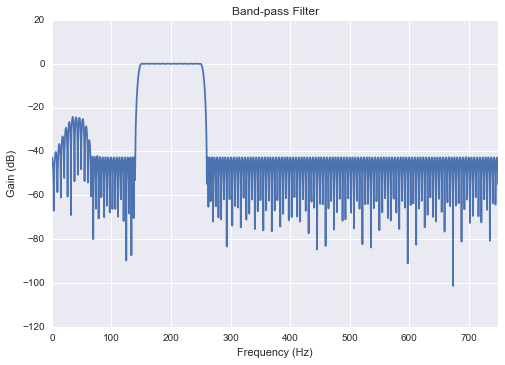

In [39]:
def plot_response(fs, w, h, title):
    plt.figure()
    plt.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    plt.xlim(0, 0.5*fs)
    plt.grid(True)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain (dB)')
    plt.title(title)

band = [150, 250]  # Desired stop band, Hz
trans_width = 10    # Width of transition from pass band to stop band, Hz
numtaps = 318        # Size of the FIR filter.
sampling_frequency = 1500

edges = [0, 
         band[0] - trans_width,
         band[0],
         band[1],
         band[1] + trans_width,
         0.5 * sampling_frequency]

taps = scipy.signal.remez(numtaps, edges, [0, 1, 0], Hz=sampling_frequency)
w, h = scipy.signal.freqz(taps, [1], worN=2000)

plot_response(sampling_frequency, w, h, "Band-pass Filter")

## Comparison to Multitaper

In [34]:
def get_segments_multitaper(lfp_dataframe, sampling_frequency, zscore_threshold=3):
    ripple_frank_df = ripples.get_ripple_zscore_multitaper(lfp_dataframe,
                                                           sampling_frequency,
                                                           zscore_threshold=zscore_threshold,
                                                           )
    ripple_above_mean_segments = segment_boolean_series(ripple_frank_df.is_above_ripple_mean)
    ripple_above_threshold_segments = segment_boolean_series(ripple_frank_df.is_above_ripple_threshold)
    return extend_segment_intervals(ripple_above_threshold_segments, ripple_above_mean_segments)


segments_multitaper = [get_segments_multitaper(lfp, sampling_frequency, zscore_threshold=2)
                       for lfp in tqdm.tqdm_notebook(CA1_lfp, desc='segments')]

KeyboardInterrupt: 